In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/Depression/Suicide_Detection.csv')

In [ ]:


# Выборка по 25 000 записей для каждого класса
suicide_sample = df[df['class'] == 'suicide'].sample(n=25000, random_state=42)
non_suicide_sample = df[df['class'] == 'non-suicide'].sample(n=25000, random_state=42)

# Объединяем выборки
df1 = pd.concat([suicide_sample, non_suicide_sample])

# Перемешиваем итоговый датасет
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)

# Сохраняем в новый файл (если нужно)
df1.to_csv("/content/drive/MyDrive/Colab Notebooks/Project/Depression/balanced_suicide_data.csv", index=False)



In [ ]:
df1.head()

,Unnamed: 0,text,class
0,265629,My frieng got a new pajama and decided to conv...,non-suicide
1,312349,I cant do thisI really don't know what to do a...,suicide
2,95121,I hate my life. There's no point to it anymore...,suicide
3,335516,Perfect lifeI suppose this is very ridiculous ...,suicide
4,141726,What's a game everyone grew up with? For me it...,non-suicide


In [ ]:
import re
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Удалить ссылки
    text = re.sub(r'[^A-Za-z0-9\s.,!?\'"]', '', text)  # Удалить спецсимволы
    text = re.sub(r'\s+', ' ', text).strip()  # Убрать лишние пробелы
    return text


In [ ]:
df1['clean text'] = df1['text'].apply(clean_text)

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [ ]:
df1.head(10)

,Unnamed: 0,text,class,clean text
0,265629,My frieng got a new pajama and decided to convince us why it was the best &amp;#x200B;\n\nhttps://preview.redd.it/msp9gkoqmy661.png?width=1000&amp;format=png&amp;auto=webp&amp;s=1b001d6ecf9a06307e1db72024f11adda934a4f4,non-suicide,My frieng got a new pajama and decided to convince us why it was the best ampx200B
1,312349,"I cant do thisI really don't know what to do anymore. Ive been doing this for so long its so tiring. Constantly helping people feel better but never having someone to help me. Being the emotional support for my friend and then for family has gotten too much. Too much negativity at home and in life itself. I have 1 friend and that's it. I had a spouse but they told me I was too much to handle mentally so they left me. I lost the one thing that was keeping me going. I cant remember the last time I felt genuine happiness, I haven't in so long. I look back and just see pain. I've attempted so many times that I cant even count on both my hands. Im gonna try again and I hope it works this time. I literally can't deal with this pain anymore. Getting constantly put through so much emotional and physical damage has worn me down too much. I just don't have anything to keep me here so why should I stay here. Im in an endless cycle of pain and I don't have or see a future on earth so it really doesn't matter. Nobody truly cares about me because in the end they all leave one way or another.",suicide,"I cant do thisI really don't know what to do anymore. Ive been doing this for so long its so tiring. Constantly helping people feel better but never having someone to help me. Being the emotional support for my friend and then for family has gotten too much. Too much negativity at home and in life itself. I have 1 friend and that's it. I had a spouse but they told me I was too much to handle mentally so they left me. I lost the one thing that was keeping me going. I cant remember the last time I felt genuine happiness, I haven't in so long. I look back and just see pain. I've attempted so many times that I cant even count on both my hands. Im gonna try again and I hope it works this time. I literally can't deal with this pain anymore. Getting constantly put through so much emotional and physical damage has worn me down too much. I just don't have anything to keep me here so why should I stay here. Im in an endless cycle of pain and I don't have or see a future on earth so it really doesn't matter. Nobody truly cares about me because in the end they all leave one way or another."
2,95121,"I hate my life. There's no point to it anymore.The option of suicide keeps crossing my mind lately. I hate it so much but I honestly don't see a downside to it at this point. Nobody gives a fuck about me. Nobody's life would change at all if i were just suddenly gone. Not one single person would even notice if I were suddenly gone. None of my ""friends"" will even talk to me anymore and I honestly have no clue why. Not like I've done something to piss off any of them. I end up sitting alone in my bedroom alone day after day, trying to get some of my ""friends"" to hang out with me, even just for a little bit. I end up just sitting around, alone and forgotten. It's like some vicious circle. Being alone and forgotten makes me more depressed, yet being depressed makes people ignore you. Until you decide that living a life of depression isn't worth it anymore and you take the most obvious way out. Then, of course, everybody talks about how that person was such a good friend, and how great a person they were, even if they didn't fucking know the lonely bastard. Seen it happen so many times already in my short life.\n\nI'm so tired of feeling like i'm fighting for my sanity constantly. I don't really even want to commit suicide. I just want this loneliness, this emptiness, to go away. I so desperately need a shoulder to cry on, but those closest to me have turned their backs on me. I don't even know what t

In [ ]:
df1[df1['clean text'].isnull()]

,Unnamed: 0,text,class,clean text


In [ ]:
df1.isna().sum()

,0
Unnamed: 0,0
text,0
class,0
clean text,0


In [ ]:
!pip install transformers


In [ ]:
from transformers import RobertaTokenizer

# Инициализация токенайзера RoBERTa
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Тексты для токенизации
texts = df1['clean text'].tolist()

# Токенизация текстов
tokenized_data = tokenizer(
    texts,                  # Список очищенных текстов
    truncation=True,        # Обрезать тексты длиннее max_length
    padding=True,           # Добавить padding для выравнивания длины
    max_length=512,         # Максимальная длина текста
    return_tensors="pt"     # Вернуть тензоры PyTorch
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
print("Keys in tokenized output:", tokenized_data.keys())
print("Example Input IDs:", tokenized_data['input_ids'][0][:10].tolist())
print("Attention Mask Example:", tokenized_data['attention_mask'][0][:10].tolist())

Keys in tokenized output: dict_keys(['input_ids', 'attention_mask'])
Example Input IDs: [0, 2387, 40404, 3314, 300, 10, 92, 181, 1176, 2583]
Attention Mask Example: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
from sklearn.model_selection import train_test_split
import torch

# Метки классов
labels = df1['class'].apply(lambda x: 1 if x == 'suicide' else 0).tolist()

# Разделение на тренировочную и тестовую выборки
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    tokenized_data['input_ids'],  # input_ids из токенизации
    labels,                      # Метки классов
    test_size=0.2,               # 20% данных на тест
    random_state=42              # Для воспроизводимости
)

# Разделение attention_mask
train_masks, test_masks = train_test_split(
    tokenized_data['attention_mask'],  # attention_mask из токенизации
    test_size=0.2,
    random_state=42
)

# Преобразование данных в тензоры PyTorch
train_inputs = train_inputs.clone().detach()
test_inputs = test_inputs.clone().detach()
train_masks = train_masks.clone().detach()
test_masks = test_masks.clone().detach()
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Проверка размеров
print(f"Train Inputs: {train_inputs.shape}")
print(f"Test Inputs: {test_inputs.shape}")
print(f"Train Labels: {train_labels.shape}")
print(f"Test Labels: {test_labels.shape}")


Train Inputs: torch.Size([40000, 512])
Test Inputs: torch.Size([10000, 512])
Train Labels: torch.Size([40000])
Test Labels: torch.Size([10000])


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Создаем PyTorch Dataset
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

# Создаем DataLoader для тренировки и теста
batch_size = 16  # Можно выбрать 16, 32 или другое значение в зависимости от доступной памяти

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,  # Перемешиваем данные для тренировочной выборки
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,  # Не перемешиваем тестовые данные
    batch_size=batch_size
)

# Проверка размеров батча
batch = next(iter(train_dataloader))
print(f"Input IDs Shape: {batch[0].shape}")  # Размер входных ID (batch_size, seq_length)
print(f"Attention Mask Shape: {batch[1].shape}")  # Размер масок внимания
print(f"Labels Shape: {batch[2].shape}")  # Размер меток


Input IDs Shape: torch.Size([16, 512])
Attention Mask Shape: torch.Size([16, 512])
Labels Shape: torch.Size([16])


In [ ]:
# Импорт необходимых библиотек
from transformers import RobertaForSequenceClassification
from torch.optim import AdamW  # Импортируем AdamW из PyTorch
from torch.nn import CrossEntropyLoss
import torch

# Инициализация модели RoBERTa для классификации
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",  # Предварительно обученная модель
    num_labels=2     # Число классов (suicide и non-suicide)
)

# Перенос модели на GPU, если доступно
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Оптимизатор AdamW из PyTorch
optimizer = AdamW(model.parameters(), lr=5e-5)

# Функция потерь (Cross-Entropy Loss)
loss_fn = CrossEntropyLoss()

# Проверка модели и устройства
print(f"Модель перенесена на устройство: {device}")
print(f"Оптимизатор AdamW настроен с lr={optimizer.param_groups[0]['lr']}")



model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель перенесена на устройство: cuda
Оптимизатор AdamW настроен с lr=5e-05


In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available. Using CPU.")


CUDA available: True
GPU Name: Tesla T4


In [ ]:
from tqdm import tqdm
import torch
from torch.amp import GradScaler, autocast

# Устанавливаем параметры обучения
epochs = 3  # Уменьшили количество эпох
scaler = GradScaler()  # Для AMP

# Функция для расчета точности
def calculate_accuracy(preds, labels):
    pred_flat = torch.argmax(preds, dim=1).flatten()
    labels_flat = labels.flatten()
    return (pred_flat == labels_flat).cpu().numpy().mean()

# Цикл обучения
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print("-" * 20)

    # ======== Этап тренировки ========
    model.train()
    train_loss = 0
    train_accuracy = 0

    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()

        # AMP: Прогон через модель
        with autocast(device_type='cuda'):
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

        # Градиентный клиппинг
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        train_accuracy += calculate_accuracy(logits, labels)

    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_accuracy = train_accuracy / len(train_dataloader)

    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Training Accuracy: {avg_train_accuracy:.4f}")

    # ======== Этап валидации ========
    model.eval()
    val_loss = 0
    val_accuracy = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Validation"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # AMP: Прогон через модель
            with autocast(device_type='cuda'):
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

            val_loss += loss.item()
            val_accuracy += calculate_accuracy(logits, labels)

    avg_val_loss = val_loss / len(test_dataloader)
    avg_val_accuracy = val_accuracy / len(test_dataloader)

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {avg_val_accuracy:.4f}")


Epoch 1/3
--------------------


Training: 100%|██████████| 2500/2500 [16:33<00:00,  2.52it/s]


Training Loss: 0.4835
Training Accuracy: 0.8014


Validation: 100%|██████████| 625/625 [01:07<00:00,  9.26it/s]


Validation Loss: 0.2550
Validation Accuracy: 0.9056
Epoch 2/3
--------------------


Training: 100%|██████████| 2500/2500 [16:35<00:00,  2.51it/s]


Training Loss: 0.2125
Training Accuracy: 0.9237


Validation: 100%|██████████| 625/625 [01:07<00:00,  9.25it/s]


Validation Loss: 0.2185
Validation Accuracy: 0.9291
Epoch 3/3
--------------------


Training: 100%|██████████| 2500/2500 [16:31<00:00,  2.52it/s]


Training Loss: 0.2160
Training Accuracy: 0.9478


Validation: 100%|██████████| 625/625 [01:07<00:00,  9.27it/s]

Validation Loss: 0.2395
Validation Accuracy: 0.9779


In [ ]:
model.eval()

test_loss = 0
test_accuracy = 0

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()
        test_accuracy += calculate_accuracy(logits, labels)

avg_test_loss = test_loss / len(test_dataloader)
avg_test_accuracy = test_accuracy / len(test_dataloader)

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {avg_test_accuracy:.4f}")


Testing: 100%|██████████| 625/625 [04:21<00:00,  2.39it/s]

Test Loss: 0.2395
Test Accuracy: 0.9779


In [ ]:
output_dir = "/content/drive/MyDrive/Colab Notebooks/Project/Depression/saved_model"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")


Model and tokenizer saved to /content/drive/MyDrive/Colab Notebooks/Project/Depression/saved_model


In [ ]:
import torch.nn.functional as F

# Пример текста для классификации
text = "I want to end my life."

# Токенизация текста
inputs = tokenizer(
    text,
    truncation=True,  # Обрезка текста, если он слишком длинный
    padding=True,     # Добавление паддинга
    max_length=512,   # Максимальная длина текста
    return_tensors="pt"  # Вернуть тензоры PyTorch
).to(device)

# Прогноз
model.eval()  # Перевод модели в режим оценки
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1)  # Преобразование логитов в вероятности
    predicted_class = torch.argmax(probs, dim=1).item()

# Вывод вероятностей
print(f"Probabilities: {probs.cpu().numpy()}")

# Установка порога
threshold = 0.7  # Порог вероятности для класса Suicide
if probs[0][1] > threshold:  # Проверяем вероятность для класса Suicide
    print("Class: Suicide")
else:
    print("Class: Non-Suicide")


Probabilities: [[2.0835087e-06 9.9999797e-01]]
Class: Suicide


In [ ]:
import torch.nn.functional as F

# Пример текста для классификации
text = "I feel so down and hopeless today."

# Токенизация текста
inputs = tokenizer(
    text,
    truncation=True,  # Обрезка текста, если он слишком длинный
    padding=True,     # Добавление паддинга
    max_length=512,   # Максимальная длина текста
    return_tensors="pt"  # Вернуть тензоры PyTorch
).to(device)

# Прогноз
model.eval()  # Перевод модели в режим оценки
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1)  # Преобразование логитов в вероятности
    predicted_class = torch.argmax(probs, dim=1).item()

# Вывод вероятностей в процентах
probs_percent = probs.cpu().numpy() * 100  # Перевод в проценты
print(f"Probabilities: Non-Suicide: {probs_percent[0][0]:.2f}%, Suicide: {probs_percent[0][1]:.2f}%")

# Установка порога
threshold = 0.7  # Порог вероятности для класса Suicide
if probs[0][1] > threshold:  # Проверяем вероятность для класса Suicide
    print("Class: Suicide")
else:
    print("Class: Non-Suicide")


Probabilities: Non-Suicide: 99.99%, Suicide: 0.01%
Class: Non-Suicide


Probabilities: Non-Suicide: 99.99%, Suicide: 0.01%


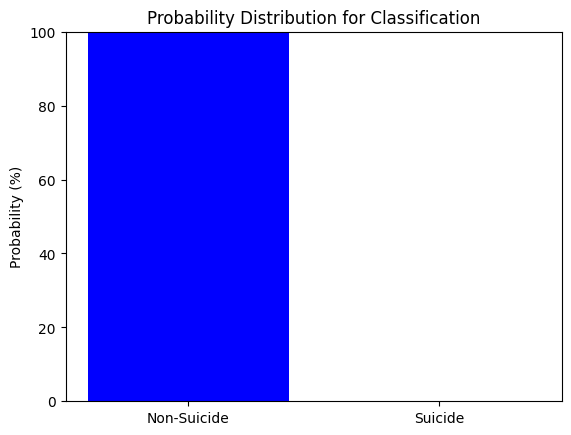

Class: Non-Suicide


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Пример текста для классификации
text = "I feel so down and hopeless today."

# Токенизация текста
inputs = tokenizer(
    text,
    truncation=True,  # Обрезка текста, если он слишком длинный
    padding=True,     # Добавление паддинга
    max_length=512,   # Максимальная длина текста
    return_tensors="pt"  # Вернуть тензоры PyTorch
).to(device)

# Прогноз
model.eval()  # Перевод модели в режим оценки
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1)  # Преобразование логитов в вероятности
    predicted_class = torch.argmax(probs, dim=1).item()

# Вывод вероятностей в процентах
probs_percent = probs.cpu().numpy() * 100  # Перевод в проценты
print(f"Probabilities: Non-Suicide: {probs_percent[0][0]:.2f}%, Suicide: {probs_percent[0][1]:.2f}%")

# Гистограмма вероятностей
labels = ["Non-Suicide", "Suicide"]
values = probs_percent[0]

plt.bar(labels, values, color=["blue", "red"])
plt.ylim(0, 100)  # Устанавливаем диапазон 0-100% для оси Y
plt.ylabel("Probability (%)")
plt.title("Probability Distribution for Classification")
plt.show()

# Интерпретация результата
threshold = 0.7  # Порог вероятности для класса Suicide
if probs[0][1] > threshold:  # Проверяем вероятность для класса Suicide
    print("Class: Suicide")
else:
    print("Class: Non-Suicide")
